# Mulitple Instance Learning

Link to notebook file: https://bu-ie-582.github.io/fall21-sametozturkk/hw4/hw4.ipynb

For this assignment we are given a dataset of 476 conformations from 92 molecules. Each molecule is flagged as musk or non-musk. It is expected to construct a model predicting the class (musk or on-musk) for any given conformation data of molecules.
To do it, we need to
* use bag encoding and get bag level data
* use a classifier to train a predictor model.

In [114]:
require(data.table)
require(randomForest)
require(caret)
set.seed(123)

In [115]:
musk = fread("Musk1.csv")

In [116]:
# Rename columns to more interpretable values  
cols <- {"bag_class"}
cols <- c(cols, "bag_id")
for (i in 1:166){cols <- c(cols, paste0("Feature_", i))}
colnames(musk) <- cols

In [117]:
bag_level = unique(musk[,c("bag_class", "bag_id")])

We can check if there is any bag with multiple classes

In [118]:
nrow(bag_level)

[1] 92

In [119]:
length(unique(bag_level$bag_id))

[1] 92

There is not.

## i) Bag encoding with descriptive stats

While trying to understand characteristics of a variable we(humans) can look for minimum value, maximum value, mean value and standard deviation. We can add quartiles etc. to the list but we don't have too many instances in a bag and I did not want to have too many columns, so I chose to add min., max., mean and std. dev. values of each feature within a bag as bag-level features. In addition, I added number of instances for each bag. 
Basically, I tried to imitate how humans would evaluate each feature of each bag.

In [121]:
bag_level = unique(musk[,c("bag_class", "bag_id")]) # get bag list with flags
counts = musk[, .(instance_count = .N), by="bag_id"] # calculate bag sizes
bag_level = merge(bag_level, counts, how="inner", by="bag_id") # add bag sizes to bag table

common_cols = c("bag_class", "bag_id")
for (i in 1:166){ # add stats for each feature
    feature_col <- paste0("Feature_", i)
    temp_cols = c(common_cols, feature_col)
    temp_df = musk[,..temp_cols]
    setnames(temp_df, feature_col, "feature")
    temp_df = temp_df[, .(
        mean = mean(feature), 
        min = min(feature), 
        max = max(feature),
        stddev = sd(feature)), 
                      by = "bag_id"] # calculate stats for selected feature

    new_cols = c("bag_id", 
                 paste0("Feature_", i, "_mean"),  
                 paste0("Feature_", i, "_min"), 
                 paste0("Feature_", i, "_max"),
                 paste0("Feature_", i, "_stddev")
                )
    colnames(temp_df) <- new_cols # rename stats
    bag_level = merge(bag_level, temp_df, how="inner", by="bag_id") # add caclulated bag level features to bag table
}
bag_level$bag_class = as.factor(bag_level$bag_class) # make bag_class a factor for classification
bag_level

bag_id,bag_class,instance_count,Feature_1_mean,Feature_1_min,Feature_1_max,Feature_1_stddev,Feature_2_mean,Feature_2_min,Feature_2_max,...,Feature_164_max,Feature_164_stddev,Feature_165_mean,Feature_165_min,Feature_165_max,Feature_165_stddev,Feature_166_mean,Feature_166_min,Feature_166_max,Feature_166_stddev
1,1,4,42.00000,42,42,0.0000000,-194.5000,-198,-191,...,-37,0.0000000,5.500000,5,6,0.5773503,30.25000,30,31,0.500000
2,1,4,42.00000,42,42,0.0000000,-194.5000,-199,-190,...,-30,0.5000000,14.000000,14,14,0.0000000,26.50000,25,29,1.732051
3,1,2,42.00000,40,44,2.8284271,-166.0000,-173,-159,...,-28,6.3639610,2.000000,-9,13,15.5563492,16.50000,-25,58,58.689863
4,1,3,42.66667,41,45,2.0816660,-154.6667,-199,-95,...,-37,1.5275252,5.333333,2,7,2.8867513,32.33333,27,38,5.507571
5,1,4,61.50000,41,85,19.8074060,-72.5000,-192,90,...,-8,13.7446959,-0.250000,-10,14,10.1447852,36.75000,-27,116,66.339405
6,1,2,46.50000,46,47,0.7071068,-148.0000,-194,-102,...,-18,14.1421356,8.000000,0,16,11.3137085,41.50000,2,81,55.861436
7,1,2,47.50000,47,48,0.7071068,-148.5000,-197,-100,...,-17,15.5563492,6.500000,-3,16,13.4350288,41.50000,0,83,58.689863
8,1,2,41.50000,40,43,2.1213203,-195.0000,-198,-192,...,-29,0.7071068,14.500000,14,15,0.7071068,26.00000,19,33,9.899495
9,1,5,44.00000,38,52,6.3639610,-152.6000,-197,-104,...,-13,11.3446022,-3.600000,-19,11,13.1453414,39.40000,-35,97,57.708752
10,1,6,44.00000,35,53,9.8590060,-155.0000,-198,-112,...,-34,5.4772256,3.166667,-7,14,11.1430098,30.66667,27,34,3.011091


In [122]:
min(bag_level$instance_count) # check the min bag size to see if std devs are meaningful / not null

[1] 2

I used tree based models. 
1- I did no want to use regression models since it may not be realistic to assume linearity on that dataset.
2- I thought time complexity might be high for k-nn with this many features. And it is hard to find a suitable distance metric.

First, I tried GBM.

In [127]:
fitControl <- trainControl(method = "cv", number = 10) # use 10 fold CV for accuracy

gbmGrid=expand.grid(interaction.depth = c(2, 3, 4), 
                    n.trees = c(1:7)*100, 
                    shrinkage = c(0.05,0.1),
                    n.minobsinnode = 4) # Introduced a grid to find the best param set

set.seed(825)
gbm_fit <- train(bag_class ~ ., data = bag_level[, -c(1)], 
                 method = "gbm", 
                 trControl = fitControl,
                 tuneGrid = gbmGrid,
                 verbose = FALSE)
gbm_fit

Stochastic Gradient Boosting 

 92 samples
665 predictors
  2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 83, 83, 83, 82, 82, 84, ... 
Resampling results across tuning parameters:

  shrinkage  interaction.depth  n.trees  Accuracy   Kappa    
  0.05       2                  100      0.7977778  0.5970079
  0.05       2                  200      0.7977778  0.5947405
  0.05       2                  300      0.7977778  0.5900419
  0.05       2                  400      0.8088889  0.6156464
  0.05       2                  500      0.7977778  0.5900419
  0.05       2                  600      0.8088889  0.6143334
  0.05       2                  700      0.7977778  0.5900419
  0.05       3                  100      0.7941667  0.5851083
  0.05       3                  200      0.7955556  0.5830813
  0.05       3                  300      0.8177778  0.6239208
  0.05       3                  400      0.8188889  0.6258720
  0.05       3   

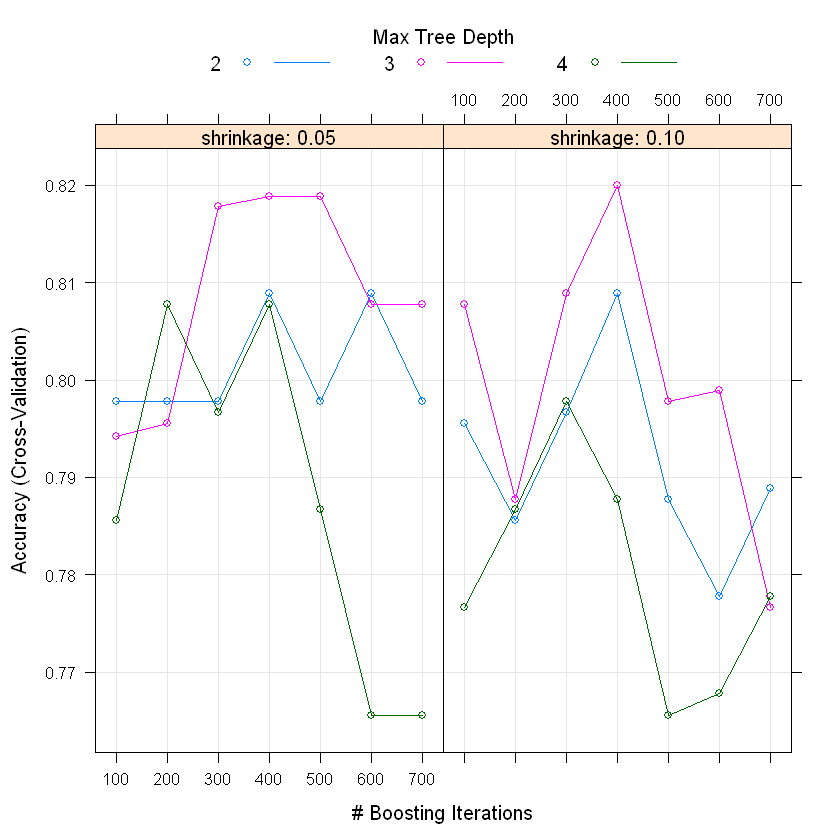

In [128]:
plot(gbm_fit)

Best model has accuracy with 10-fold CV is 82% for
* learning_rate = 0.1
* number of tree = 400
* Max Tree depth = 4

Next, I tried Fandom forest.

In [129]:
rfGrid=expand.grid(mtry=c(1:60)*2)
set.seed(825)
rf_fit <- train(bag_class ~ ., data = bag_level[, -c(1)], 
                method = "rf", 
                trControl = fitControl,
                tuneGrid = rfGrid,
                verbose = FALSE)
rf_fit

Random Forest 

 92 samples
665 predictors
  2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 83, 83, 83, 82, 82, 84, ... 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa    
    2   0.8488889  0.6921905
    4   0.8166667  0.6208720
    6   0.8277778  0.6449661
    8   0.8277778  0.6428232
   10   0.8177778  0.6262088
   12   0.8277778  0.6473064
   14   0.7955556  0.5799661
   16   0.8288889  0.6458720
   18   0.8188889  0.6248267
   20   0.8388889  0.6682123
   22   0.8288889  0.6482123
   24   0.8177778  0.6251635
   26   0.8488889  0.6858720
   28   0.8600000  0.7101635
   30   0.8288889  0.6470866
   32   0.8177778  0.6273064
   34   0.8388889  0.6682123
   36   0.8277778  0.6461806
   38   0.8500000  0.6901635
   40   0.8511111  0.6910694
   42   0.8388889  0.6682123
   44   0.8188889  0.6270866
   46   0.8488889  0.6858720
   48   0.8400000  0.6701635
   50   0.8166667  0.6230149
   52   0.8188889  0.6

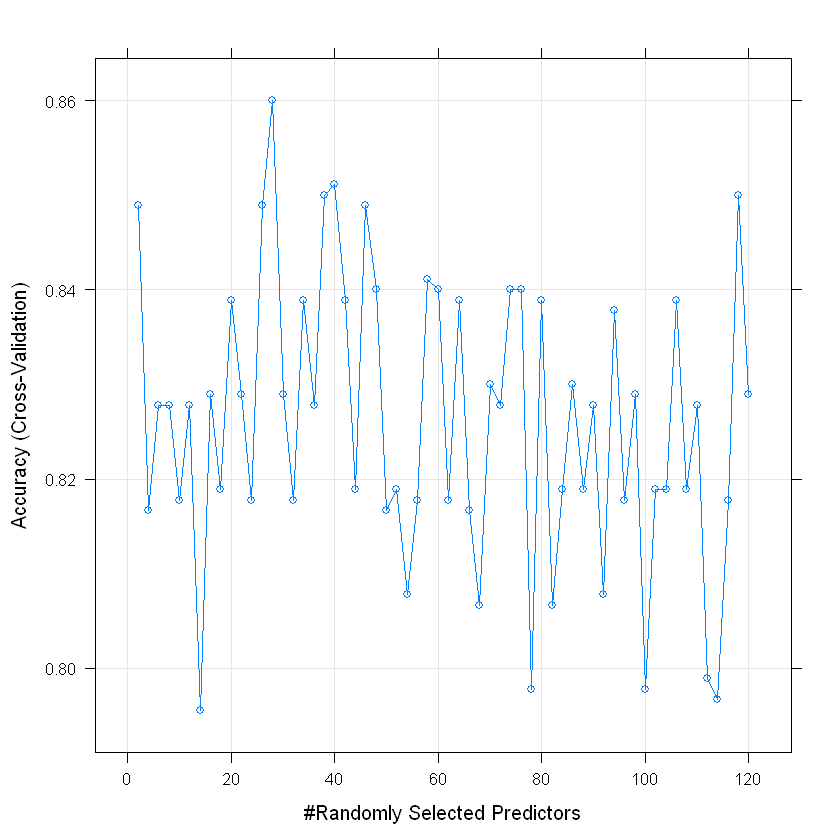

In [130]:
plot(rf_fit)

Best model has accuracy with 10-fold CV is 86% for
* mtry(number of vars as candidate at splits) = 28

# Bag Encoding with PCA

While talking with my project partner Sualp, he mentioned him using PCA for the assignment. I asked if I can use it, as well. I am not sure how he used but here is how I used it:
For each bag, we are trying to reduce the dimension and get one dimension, basically. So we can treat each bag instance as a variable and apply pca to get one component explaining most variation of the bag.
Linearity assumption for PCA here is a bold assumption and a little problematic.

In [134]:
bag_level_pca = musk[0, -1] #create blank data table

In [135]:
for (i in 1:92){ # for each bag
    temp_bag = musk[musk$bag_id==i,-c(1,2)] # get feature of instances from the selected bag
    transpose_bag = transpose(temp_bag) # take transpose so that we can perform PCA on them as if they are varaibles
    pca <- princomp(transpose_bag, cor=TRUE)
    bag_level_pca = rbind(bag_level_pca, as.list(c(i, pca$scores[,1]))) # Get the first component and add them as bag level feature vector
}

In [136]:
bag_classes = unique(musk[,c("bag_class", "bag_id")]) # get bag classes
bag_level_pca = merge(bag_classes, bag_level_pca, how="inner", key="bag_id") # merge features add bag class
bag_level_pca$bag_class = as.factor(bag_level_pca$bag_class)

In [137]:
bag_level_pca

bag_id,bag_class,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,...,Feature_157,Feature_158,Feature_159,Feature_160,Feature_161,Feature_162,Feature_163,Feature_164,Feature_165,Feature_166
1,1,2.14245252,-2.2343632,-0.96257135,0.06735774,-0.8001816,1.9657863,2.0318599,-1.0124493,...,-3.0395447,-2.05708660,0.69277346,-0.85570299,0.6528579,1.92488316,2.2534953,0.68038903,1.46692486,1.9251216
2,1,1.88739948,-2.3124450,-1.02629748,-0.10372754,-0.9364499,1.7187918,1.7860426,-1.1321654,...,-3.0854170,-2.12080706,0.52690193,2.04724001,3.3878550,3.69001928,1.9010369,0.60432641,1.39011783,1.6125795
3,1,1.29891816,-1.2970508,-0.50180264,0.39028448,-0.6797662,0.8378659,1.1159564,-1.0019867,...,-2.1651092,0.05638336,0.20128193,0.93475895,2.2812442,2.44095100,1.4664301,0.36844706,0.79857368,0.9771246
4,1,1.81868954,-1.3067548,-0.09208331,0.45331096,-0.7294256,1.4873823,1.4884424,-0.9801198,...,-2.6516107,-1.08494466,0.84555787,-0.13616299,0.6006508,1.63797529,1.9415313,0.52672102,1.22369200,1.6548346
5,1,1.97133268,-0.2880485,-0.78791868,0.50588805,0.3555704,1.2532840,1.4223316,-1.4887173,...,-3.0802407,-1.04394418,-0.08908703,1.01656228,2.2079553,3.23937456,2.0905350,0.48200448,0.92897564,1.5554475
6,1,1.46197335,-0.8941418,-0.35364437,0.33513937,-0.5536340,0.3624623,1.4225753,-1.3517282,...,-2.0714300,-1.25116642,-0.04057470,1.05187994,1.7543345,2.46088416,1.6667316,0.55233788,0.99423442,1.4355925
7,1,1.45474242,-1.3934189,-0.70153569,0.41798129,-0.9465861,0.7080478,1.5465470,-0.1931618,...,-2.7568727,-1.75502122,0.58983548,0.96448599,1.7844765,2.59699101,1.6872794,0.35548233,0.85867522,1.3781255
8,1,1.48408162,-2.2087665,-1.59222231,-0.32618559,-0.9904976,0.4992942,1.4292350,0.4024975,...,-2.8885599,-0.58784980,1.27799551,1.62500241,2.8115143,3.06120175,1.5082303,0.37577083,1.06277539,1.2431939
9,1,1.70092296,-2.5000780,-2.11971097,1.64220923,-1.2545036,-0.9043001,2.1296040,1.3443031,...,-3.4850113,-4.19803351,-3.29246443,1.45834904,2.5012410,3.23401183,2.2014970,0.31690661,0.88641819,1.8629760
10,1,2.36018251,-0.9383848,0.91434173,-0.03652605,-0.8762554,1.6250340,-1.3962803,3.0852946,...,-3.2012561,-1.95403232,1.77186712,0.80813218,0.9082298,2.25679056,2.5833570,0.85640871,1.83644056,2.1901072


Apply GBM

In [138]:
fitControl <- trainControl(method = "cv", number = 10)

gbmGrid=expand.grid(interaction.depth = c(2, 3, 4), 
                    n.trees = c(1:10)*100, 
                    shrinkage = c(0.05,0.1),
                    n.minobsinnode = 4)

set.seed(825)
gbm_fit <- train(bag_class ~ ., data = bag_level_pca[, -c(1)], 
                 method = "gbm", 
                 trControl = fitControl,
                 tuneGrid = gbmGrid,
                 verbose = FALSE)
gbm_fit

Stochastic Gradient Boosting 

 92 samples
166 predictors
  2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 83, 83, 83, 82, 82, 84, ... 
Resampling results across tuning parameters:

  shrinkage  interaction.depth  n.trees  Accuracy   Kappa    
  0.05       2                   100     0.8188889  0.6393621
  0.05       2                   200     0.7866667  0.5752100
  0.05       2                   300     0.7977778  0.5949902
  0.05       2                   400     0.8188889  0.6424251
  0.05       2                   500     0.8088889  0.6204355
  0.05       2                   600     0.8311111  0.6643902
  0.05       2                   700     0.8311111  0.6643902
  0.05       2                   800     0.8197222  0.6413415
  0.05       2                   900     0.7975000  0.5963415
  0.05       2                  1000     0.8086111  0.6182645
  0.05       3                   100     0.8411111  0.6843380
  0.05       3   

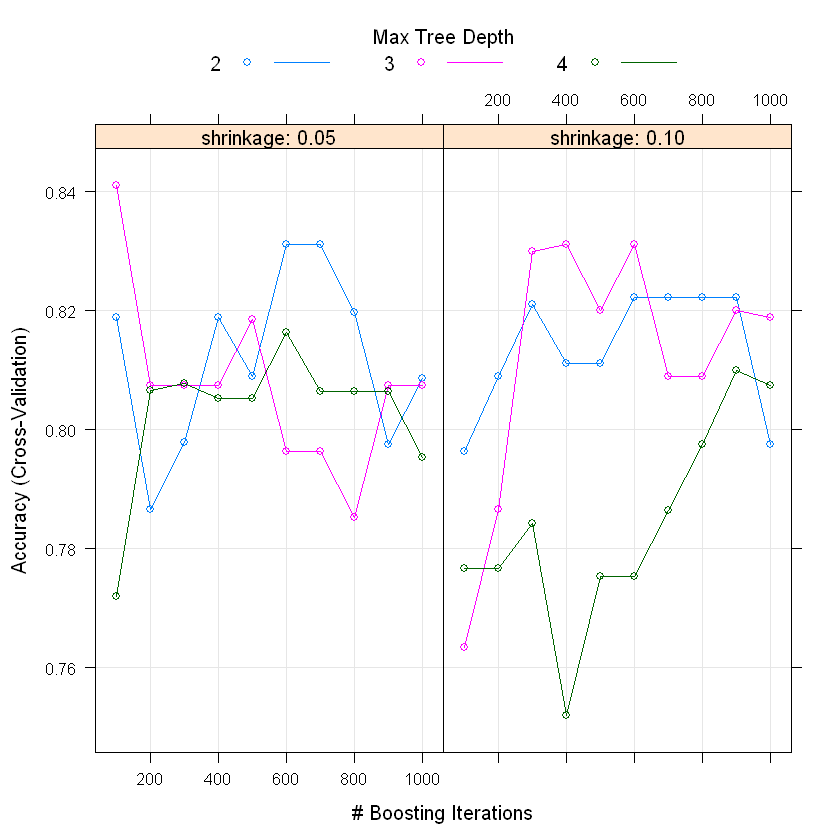

In [139]:
plot(gbm_fit)

Best model has accuracy with 10-fold CV is 84% for
* learning_rate = 0.05
* number of tree = 100
* Max Tree depth = 3

In [131]:
rfGrid=expand.grid(mtry=c(1:40)*2)
set.seed(825)
rf_fit <- train(bag_class ~ ., data = bag_level_pca[, -c(1)], 
                method = "rf", 
                trControl = fitControl,
                tuneGrid = rfGrid,
                verbose = FALSE)
rf_fit

Random Forest 

 92 samples
166 predictors
  2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 83, 83, 83, 82, 82, 84, ... 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa    
   2    0.7530556  0.5005071
   4    0.7752778  0.5490619
   6    0.7763889  0.5531037
   8    0.7663889  0.5331037
  10    0.7430556  0.4861244
  12    0.7863889  0.5731037
  14    0.7963889  0.5931037
  16    0.7766667  0.5542013
  18    0.7641667  0.5303551
  20    0.7641667  0.5291209
  22    0.7541667  0.5080474
  24    0.7530556  0.5061244
  26    0.7741667  0.5491731
  28    0.7630556  0.5261244
  30    0.7641667  0.5291731
  32    0.7555556  0.5121978
  34    0.7741667  0.5491209
  36    0.7519444  0.5042013
  38    0.7319444  0.4642013
  40    0.7530556  0.5061244

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was mtry = 14.

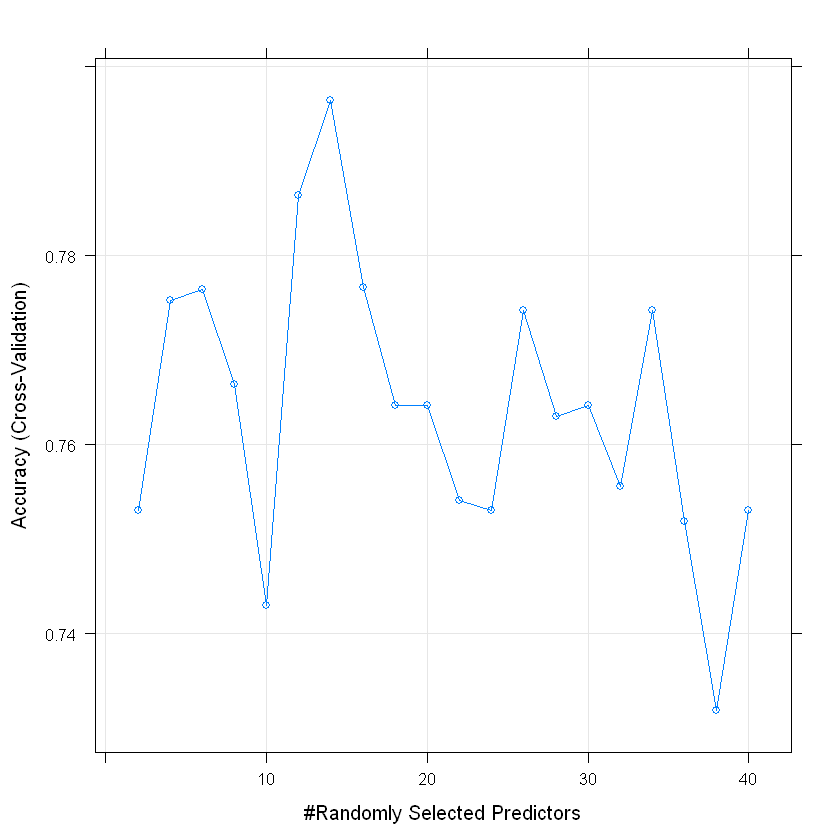

In [132]:
plot(rf_fit)

Best model has accuracy with 10-fold CV is 80% for
* mtry(number of vars as candidate at splits) = 14

To compare all, the best accuracy (86%) is from RF learner using bag encoding with feature statistics.